# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [60]:
import io
import os
import numpy as np
import scipy

In [61]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [62]:
class Word2vec():
    
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        if (w not in self.word2vec):
            print('input word is not in word2vec loaded vocab')
            return []
        else:
            similarity_scores = [self.score(w, w_dict) for w_dict in self.word2vec]
            idx_matches = np.argsort(similarity_scores)[::-1][:K]
            matches = (np.array(list(self.word2vec.keys()))[idx_matches]).tolist()
        return matches
    

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if (w1 not in self.word2vec) or (w2 not in self.word2vec):
            return 0
        else:
            emb1 = self.word2vec[w1]
            emb2 = self.word2vec[w2]
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        return similarity



In [63]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 25000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0
germany berlin 0
['cat', 'cats', 'kitty', 'kitten', 'Cat']
['dog', 'dogs', 'puppy', 'Dog', 'canine']
['dogs', 'dog', 'Dogs', 'puppies', 'cats']
input word is not in word2vec loaded vocab
[]
input word is not in word2vec loaded vocab
[]


In [64]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        idf_dic = idf
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                list_embeddings = [self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(list_embeddings)==0: #if any word in the sentence is in our lookup table
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                else:
                    sentemb.append(np.mean(list_embeddings, axis=0))
            else:
                # idf-weighted mean of word vectors
                list_embeddings = [idf_dic[w]*self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(list_embeddings)==0: #if any word in the sentence is in our lookup table
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                else:
                    sentemb.append(np.mean(list_embeddings, axis=0))
        return np.vstack(sentemb)
    

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        #keys = self.encode(sentences, idf)
        #query = self.encode([s], idf)
        scores = [self.score(s, sent, idf) for sent in sentences]
        idx_matches = np.argsort(scores)[::-1][:K]
        matches = []
        print('Top %s NNs of' %K, ' '.join(s))
        if len(scores)==0:
            print('not recognized')
        if max(scores)==0:
            print('input contains words unknown to our vocab')
        else:
            for idx_print, idx_match in enumerate(idx_matches):
                curr_match = sentences[idx_match]
                print(str(idx_print + 1) + '/ ' + ' '.join(curr_match))
                matches.append(curr_match)
        return matches
    

    def score(self, s1, s2, idf=False):
        emb2 = self.encode([s2], idf)
        emb1 = self.encode([s1], idf)
        # edge case: 0-vector embedding
        if np.linalg.norm(emb1)==0 or np.linalg.norm(emb2)==0:
            return 0
        else:
            similarity = np.dot(emb1, emb2.T) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        return similarity
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1        
        for w in idf:
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf

In [65]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"

with open(os.path.join(PATH_TO_DATA,'sentences.txt')) as f:
    sentences = f.readlines()

sentences = [sent.split() for sent in sentences]
# Build idf scores for each word
idf = {} if False else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors
Top 5 NNs of 1 smiling african american boy .
1/ 1 smiling african american boy .
2/ blond boy waterskiing .
3/ a boy jumps .
4/ a boy jumps .
5/ a boy smiles underwater .
[[0.60894451]]
Top 5 NNs of 1 smiling african american boy .
1/ 1 smiling african american boy .
2/ 5 women and 1 man are smiling for the camera .
3/ a man rides a 4 wheeler in the desert .
4/ 3 males and 1 woman enjoying a sporting event
5/ a man in black is juggling 3 flamed bottles .
[[0.59633357]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [66]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

w2v_eng = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [67]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

words_in_both_vocab = [w for w in w2v_eng.word2vec if w in w2v_fr.word2vec]
X = np.array([w2v_eng.word2vec[word] for word in words_in_both_vocab])
Y = np.array([w2v_fr.word2vec[word] for word in words_in_both_vocab])

In [68]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

X = X[:200]
Y = Y[:200]
U, s, Vh = np.linalg.svd(Y.dot(X.T))
W = U.dot(Vh)

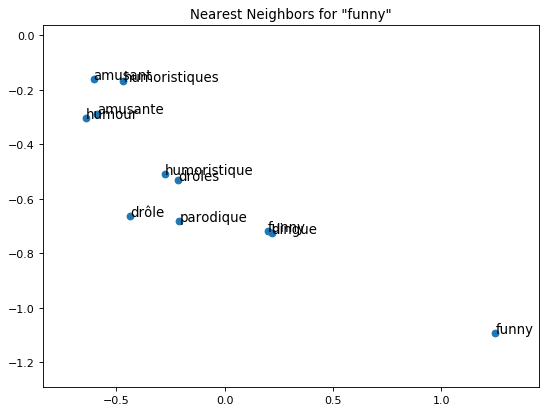

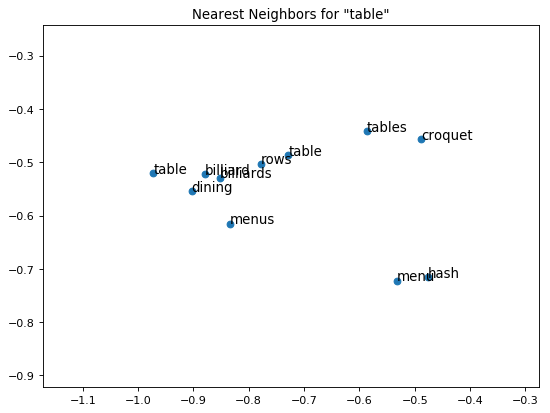

In [69]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
import scipy.linalg as la
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline  


class BilingWord2Vec:
    
    '''Class aligning two vocabularies and translating between them'''
    
    def __init__(self, w2v_1, w2v_2):
        self.w2v_lang_1 = w2v_1
        self.w2v_lang_2 = w2v_2
        
    def align(self, max_size):
        
        '''Procrustes alignment between languages'''

        words_in_both_vocab = [w for w in self.w2v_lang_1.word2vec if w in self.w2v_lang_2.word2vec][: max_size]
        
        # Solving Procrustes alignment
        X = np.vstack([self.w2v_lang_1.word2vec[w] for w in words_in_both_vocab]).T
        Y = np.vstack([self.w2v_lang_2.word2vec[w] for w in words_in_both_vocab]).T
        U, s, Vh = la.svd(Y.dot(X.T))
        
        return U.dot(Vh)
    
    def nearest_matches(self, word, W_alignement, K=5, lang_input = 1, lang_output=2):
        
        '''Solves the nearest neighbors problem across languages'''

        # defining input and output languages for the translation
        if lang_input == 1: 
            word2vec_1 = self.w2v_lang_1.word2vec
        else:
            word2vec_1 = self.w2v_lang_2.word2vec
            
        if lang_output == 1:  
            word2vec_2 = self.w2v_lang_1.word2vec
        else:
            word2vec_2 = self.w2v_lang_2.word2vec
        
        # define a candidate translation: project input word on output space
        query = W_alignement.dot(word2vec_1[word]) if word in word2vec_1 else 0 
        
        # apply classical K Nearest Neigbors
        keys = word2vec_2.values()
        scores = [self.score(query,key) for key in keys]
        index_matches = (np.argsort(scores)[::-1][: K])
        matches = np.array(list(word2vec_2.keys()))[index_matches]
        
        return matches
    

    def score(self, emb1, emb2):
        
        # cosine similarity
        if ((np.linalg.norm(emb1)!=0) and ((np.linalg.norm(emb2)!=0))):
            return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        else:
            return 0
        
    def plot_nearest_matches(self, word, W_alignement, pca, K=5, lang_input = 1, lang_output=2):
        
        '''Plots the nearest matches problem defined in a function above'''

        # defining input and output languages for the translation
        if lang_input == 1:  
            word2vec_1 = self.w2v_lang_1.word2vec
        else:
            word2vec_1 = self.w2v_lang_2.word2vec
        
        if lang_output == 1:  
            word2vec_2 = self.w2v_lang_1.word2vec
        else:
            word2vec_2 = self.w2v_lang_2.word2vec
            
        # initializing storage to collect input word and nearest matches positions in the ouput space 
        word_embedding_dim = list(word2vec_2.values())[0].shape[0]
        outputs = np.empty((0, word_embedding_dim), dtype='f')
        
        # labels: input word and matches
        word_labels = []
        
        word_labels.append(word)
        
        word_matches = self.nearest_matches(word, W_alignement, K, lang_input, lang_output)
        word_labels += word_matches.tolist()
        
        # output positions: input word and matches
        
            # input word
        word_position = W_alignement.dot(word2vec_1[word]) if word in word2vec_1 else np.zeros(word_embedding_dim)
        outputs = np.append(outputs, np.array([word_position]), axis=0)
        
            # reverse-engineer vector-form of word-matches
        for word_match in word_matches:
            vector_match = word2vec_2[word_match]
            outputs = np.append(outputs, np.array([vector_match]), axis=0)

        # PCA to 2D
        np.set_printoptions(suppress=True)
        outputs_reduced = pca.transform(outputs)

        x = outputs_reduced[:, 0]
        y = outputs_reduced[:, 1]
        
        # plot
        plt.figure(figsize=(8, 6), dpi=80)
        plt.scatter(x, y)

        for label, x_coor, y_coor in zip(word_labels, x, y):
            plt.annotate(label, xy=(x_coor, y_coor), xytext=(0, 0), textcoords='offset points', fontsize=12)
        plt.xlim(x.min()-0.2, x.max()+0.2)
        plt.ylim(y.min()-0.2, y.max()+0.2)
        plt.title('Nearest Neighbors for "%s"' % word)
        
        plt.show()

# instantiate class
max_size = 18000
biw2vec = BilingWord2Vec(w2v_eng,w2v_fr)

# activate alignment
W = biw2vec.align(max_size) 

# define PCA mapping
pca = PCA(n_components=2)
pca.fit(np.array(list(biw2vec.w2v_lang_2.word2vec.values())))

# plot
biw2vec.plot_nearest_matches('funny', W, pca, K=10) 
biw2vec.plot_nearest_matches('table', W.T, pca, K=10, lang_input=2, lang_output=1) 


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [70]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def read_training(file_path):
    
    '''Reads SST file: train'''
    
    with open(file_path,'r') as f:
        lines = f.readlines()
    y_train= [int(line[0]) for line in lines] 
    x_train= [line[2:].split() for line in lines]
    return x_train, y_train

def read_test(file_path):

    '''Reads SST file: test'''

    with open(file_path,'r') as f:
        lines = f.readlines()
    x_test = [line.split() for line in lines]
    return x_test

x_train,y_train = read_training(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
x_dev,y_dev = read_training(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
x_test = read_test(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'))

In [71]:
# 2 - Encode sentences with the BoV model above

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
s2v = BoV(w2v)

idf = {} if False else s2v.build_idf(x_train + x_dev + x_test)

x_train_encode = s2v.encode(x_train)
x_dev_encode = s2v.encode(x_dev)
x_test_encode = s2v.encode(x_test)

x_train_encode_idf = s2v.encode(x_train,idf)
x_dev_encode_idf = s2v.encode(x_dev,idf)

Loaded 50000 pretrained word vectors


In [72]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import accuracy_score as acc_score

lr = LogReg(C = 0.7, max_iter=1000, tol=1e-10)
lr.fit(x_train_encode, y_train)
prediction_dev = lr.predict(x_dev_encode)
prediction_train = lr.predict(x_train_encode)

lr_idf = LogReg(C = 0.5,max_iter=1000,tol=1e-10)
lr_idf.fit(x_train_encode_idf, y_train)
prediction_dev_idf = lr_idf.predict(x_dev_encode_idf)
prediction_train_idf = lr_idf.predict(x_train_encode_idf)


print('Train Accuracy', acc_score(y_train, prediction_train))
print('Dev Accuracy', acc_score(y_dev, prediction_dev))

print('Train Accuracy (idf-weighted)', acc_score(y_train, prediction_train_idf))
print('Dev Accuracy (idf-weighted) ', acc_score(y_dev, prediction_dev_idf))

/Users/omar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/omar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/omar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/omar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train Accuracy 0.4554073033707865
Dev Accuracy 0.4069028156221617
Train Accuracy (idf-weighted) 0.4618445692883895
Dev Accuracy (idf-weighted)  0.3860127157129882


In [73]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

def save_submission(path_output,prediction):
    lines = '\n'.join([str(p) for p in prediction])
    with open(path_output,'w') as f:
        f.writelines(lines)

prediction_test = lr.predict(x_test_encode)
save_submission(os.path.join('.',r'logreg_bov_y_test_sst.txt'), prediction_test)

In [74]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.ensemble import RandomForestClassifier as RF

model = RF(n_estimators=100)
model.fit(x_train_encode,y_train)
prediction_dev_rf = model.predict(x_dev_encode)
prediction_train_rf = model.predict(x_train_encode)


model = RF(n_estimators=100)
model.fit(x_train_encode_idf, y_train) 
prediction_dev_rf_idf = model.predict(x_dev_encode_idf)
prediction_train_rf_idf = model.predict(x_train_encode_idf)


print('Random Forest Precision sur le train set', acc_score(y_train,prediction_train_rf))
print('Random Forest Precision sur le dev set', acc_score(y_dev,prediction_dev_rf))

print('Random Forest Precision sur le train set idf', acc_score(y_train,prediction_train_rf_idf))
print('Random Forest Precision sur le dev set idf', acc_score(y_dev,prediction_dev_rf_idf))

# a Random Forest, with its in-built feature selection (ex: through entropy criterion)
# and its powerful non-linear capacity to fit data by dividing a space in hypercubes, 
# is performing no better than the Logistic Regression on the test set 

Random Forest Precision sur le train set 0.9985955056179775
Random Forest Precision sur le dev set 0.3723887375113533
Random Forest Precision sur le train set idf 0.9985955056179775
Random Forest Precision sur le dev set idf 0.35967302452316074


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [75]:
import keras

In [76]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

x_train, y_train = read_training(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
x_dev, y_dev = read_training(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
x_test = read_test(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'))

In [77]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text
from keras.utils import to_categorical

words = set([word for sentence in (x_train + x_dev + x_test) for word in sentence ])
n_words = len(words)


x_train = [text.one_hot(' '.join(x), n_words) for x in x_train]
x_dev = [text.one_hot(' '.join(x), n_words) for x in x_dev]
x_test = [text.one_hot(' '.join(x), n_words) for x in x_test]


y_train = to_categorical(y_train)
y_val = to_categorical(y_dev)

print(y_train.shape)

(8544, 5)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [78]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=30)
x_val = pad_sequences(x_dev, maxlen=30)
x_test = pad_sequences(x_test, maxlen=30)

## 4.2 - Design and train your model

In [79]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  
n_hidden = 100  
vocab_size = n_words  
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(n_hidden, dropout_W=0.2, dropout_U=0.2,return_sequences=False))
model.add(Dense(n_classes, activation='softmax'))

/Users/omar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`


In [80]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
loss_classif     =  'categorical_crossentropy' 
optimizer        =  'rmsprop' 
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         5860800   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 6,021,705
Trainable params: 6,021,705
Non-trainable params: 0
_________________________________________________________________
None


/Users/omar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 14s 2ms/step - loss: 1.5341 - acc: 0.3150 - val_loss: 1.4478 - val_acc: 0.3797
Epoch 2/6
8544/8544 [==============================] - 13s 2ms/step - loss: 1.2761 - acc: 0.4618 - val_loss: 1.4042 - val_acc: 0.3733
Epoch 3/6
8544/8544 [==============================] - 13s 1ms/step - loss: 1.0529 - acc: 0.5742 - val_loss: 1.4285 - val_acc: 0.4042
Epoch 4/6
8544/8544 [==============================] - 13s 2ms/step - loss: 0.8692 - acc: 0.6664 - val_loss: 1.6283 - val_acc: 0.3724
Epoch 5/6
8544/8544 [==============================] - 12s 1ms/step - loss: 0.7136 - acc: 0.7375 - val_loss: 1.7941 - val_acc: 0.3742
Epoch 6/6
8544/8544 [==============================] - 13s 1ms/step - loss: 0.5834 - acc: 0.7864 - val_loss: 1.9239 - val_acc: 0.3824
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


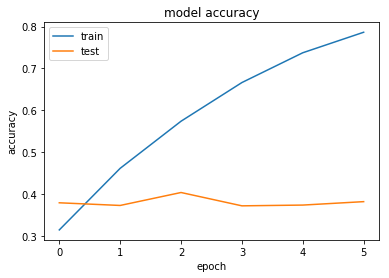

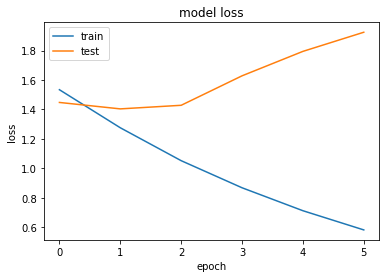

In [81]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import ModelCheckpoint

mcp1 = ModelCheckpoint('weights.best.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)

bs = 64
n_epochs = 6

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_val, y_val), callbacks = [mcp1])

print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [82]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
model = keras.models.load_model('weights.best.hdf5') 
prediction_test_one_hot = model.predict(x_test)
prediction_test = [np.argmax(pred) for pred in prediction_test_one_hot]

def write_submission(path_output,prediction):
    lines = '\n'.join([str(p) for p in prediction])
    with open(path_output,'w') as f:
        f.writelines(lines)
    
write_submission(os.path.join('.',r'logreg_lstm_y_test_sst.txt'),prediction_test)

## 4.3 -- innovate !

In [83]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation,Dropout, Conv1D, Flatten
from keras.layers import Bidirectional 
from keras.optimizers import RMSprop
from keras import backend as K

embed_dim  = 300  
n_hidden = 50  
vocab_size = n_words  
n_classes  = 5

mcp1 = ModelCheckpoint('weights.best_innovate.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)

#Create the pretrained embedding matrix

embedding_matrix = np.zeros((vocab_size, embed_dim))
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
for w in words:
    if w in w2v.word2vec:

        index = w,text.one_hot(w,n_words)
        if len(index)==1:
            id_w = text.one_hot(w,n_words)[0]
            embedding_matrix[id_w] = w2v.word2vec[w]

# using BiDirectional LSTM in architecture (as in BERT)
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(n_hidden, dropout_W=0.3, dropout_U=0.3,return_sequences=False))) 
model.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' 
optimizer        =  RMSprop(lr=1e-3,decay=1e-5) 
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 64
n_epochs = 8

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val),callbacks = [mcp1])

model = keras.models.load_model('weights.best_innovate.hdf5') #best score on dev 0.3915


get_layer_output = K.function([model.layers[0].input,K.learning_phase()], [model.layers[1].output])
layer_output_train = get_layer_output([x_train, 0])[0]
layer_output_dev = get_layer_output([x_val, 0])[0]
layer_output_test = get_layer_output([x_test,0])[0]

y_train_rf = np.argmax(y_train,axis=1)
y_dev_ref = y_dev

from sklearn.svm import SVC

model = SVC(C=0.3)
model.fit(layer_output_train,y_train_rf)
prediction_dev = model.predict(layer_output_dev)
prediction_train = model.predict(layer_output_train)
prediction_test = model.predict(layer_output_test)

print('Precision sur le train set', acc_score(y_train_rf,prediction_train))
print('Precision sur le dev set', acc_score(y_dev_ref,prediction_dev))

save_submission(os.path.join('.',r'bidirectional_lstm_svm_y_test_sst.txt'),prediction_test)


Loaded 200000 pretrained word vectors


/Users/omar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         5860800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 6,001,705
Trainable params: 6,001,705
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8544/8544 [==============================] - 18s 2ms/step - loss: 1.5113 - acc: 0.3271 - val_loss: 1.4103 - val_acc: 0.3742
Epoch 2/8
8544/8544 [==============================] - 16s 2ms/step - loss: 1.2667 - acc: 0.4635 - val_loss: 1.3659 - val_acc: 0.4051
Epoch 3/8
8544/8544 [==============================] - 16s 2ms/step - loss:

/Users/omar/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Precision sur le train set 0.5812265917602997
Precision sur le dev set 0.4114441416893733
